In [1]:
import os
import numpy as np

from scipy import interpolate
from scipy import optimize
import scipy
from scipy import sparse
from scipy.sparse.linalg import spsolve

import datetime

from astropy import coordinates as coord
from astropy import units as u
from astropy import constants as const
from astropy import time as astrotime
from astropy.coordinates import Angle

from matplotlib import pyplot as plt
from math import pi

In [2]:
class Transit:
    def __init__(self, date, dec_L, dec_mid, dec_R, horn, noon):
        self.date = date
        self.dec_mid = dec_mid
        self.dec_L = dec_L
        self.dec_R = dec_R
        self.horn = horn
        self.noon = noon
    def get_data(self):
        folder = os.path.join(f"data/{self.date}")
        #print(os.listdir(folder))
        datetimes = np.load(os.path.join(folder, 'datetimes.npy'), allow_pickle=True)
        a1p1 = np.load(os.path.join(folder, 'a1p1_bandpass.npy'), allow_pickle=True)
        a1p2 = np.load(os.path.join(folder, 'a1p2_bandpass.npy'), allow_pickle=True)
        a2p1 = np.load(os.path.join(folder, 'a2p1_bandpass.npy'), allow_pickle=True)
        a2p2 = np.load(os.path.join(folder, 'a2p2_bandpass.npy'), allow_pickle=True)
        power_array = np.stack((a2p1, a1p2, a1p1, a2p2))

        # a1p1, a2p2 = WEST, a1p2, a2p1 = EAST

        return datetimes, power_array

sc_transit = np.load(os.path.join('C:/Users/w82312eh', 'bandpass_powers_20240718.npy'), allow_pickle=True)
print(sc_transit.shape)

sc_pwr_mins = np.empty((179,100))

for i in range(100):
    sc_pwr_ms = sc_transit[:,i][0:10740000]
    sc_pwr_mins[:,i] = np.sum(sc_pwr_ms.reshape(179,60000), axis=1)

In [3]:
def gaussian_with_baseline(x, a, b, c, d, m):
    return a*np.exp(-((x-b)**2)/(2*(c/(2*np.sqrt(2*np.log(2))))**2)) + m*x + d

def gaussian_with_baseline_fitting(x, y):
    p0 = np.array([np.max(y), x[np.argmax(y)], 23, 0, 0])
    popt, pcov = scipy.optimize.curve_fit(gaussian_with_baseline, x, y, absolute_sigma=0, p0=p0)
    #absolute_sigma=0 to ensure uncertainties reflect the fitting
    return popt, pcov

def line_fitting(x_data, y_data, y_uncertainties):

    weights = 1. / y_uncertainties**2
    repeated_term = (np.sum(weights) * np.sum(x_data**2 * weights) - np.sum(x_data * weights)**2)

    slope = ((np.sum(weights) * np.sum(x_data * y_data * weights) - np.sum(x_data * weights) * np.sum(y_data * weights)) / repeated_term)
    slope_uncertainty = np.sqrt(np.sum(weights) / repeated_term)

    offset = ((np.sum(y_data * weights) * np.sum(x_data**2 * weights) - np.sum(x_data * weights) * np.sum(x_data * y_data * weights)) / repeated_term)
    offset_uncertainty = np.sqrt(np.sum(x_data**2 * weights) / repeated_term)

    return (np.array([slope, offset]), np.array([slope_uncertainty, offset_uncertainty]))

angle = np.cos(20.873053993789906*np.pi/180) * np.linspace(1,179,179) * 360/(60*24)

tot_sc_pwr = np.sum(sc_pwr_mins, axis=1)/np.max(np.sum(sc_pwr_mins, axis=1))
plt.plot(angle, tot_sc_pwr, ".")

tot_sc_pwr = np.append(tot_sc_pwr[:58] + 0.06,tot_sc_pwr[58:])
plt.plot(angle, tot_sc_pwr, ".")

#popt, pcov = gaussian_with_baseline_fitting(angle[58:], tot_sc_pwr[58:])
popt, pcov = gaussian_with_baseline_fitting(angle, tot_sc_pwr)

fwhm = popt[2]
fwhm_error = np.sqrt(np.diag(pcov)[2])

plt.figure(figsize=(10, 5))
plt.plot(angle, tot_sc_pwr, "k.")
plt.plot(np.linspace(np.min(angle), np.max(angle), 1000), gaussian_with_baseline(np.linspace(np.min(angle), np.max(angle), 1000), *popt), "r")
plt.xlabel('Angle moved through by Sun [degrees]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.title("Solar Drift Scan 18/07/24")
plt.annotate(f"FWHM = {fwhm:.2f} ± {fwhm_error:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.show()

angle = np.cos(20.873053993789906*np.pi/180) * np.linspace(1,179,179) * 360/(60*24)
fwhm_freq = np.empty((95))
fwhm_freq_error = np.empty((95))
freq = np.linspace(1419, 1421, 95)

for i in range(5, 100):
    chnl_pwr = sc_pwr_mins[:,i]/np.max(sc_pwr_mins[:,i])
    factor = (chnl_pwr[59]-chnl_pwr[58]) - (chnl_pwr[60]-chnl_pwr[59])
    fixed_pwr = np.append(chnl_pwr[:58] + 0.06,chnl_pwr[58:])
    popt, pcov = gaussian_with_baseline_fitting(angle, fixed_pwr)
    fwhm_freq[i-5] = popt[2]
    fwhm_freq_error[i-5] = np.sqrt(np.diag(pcov)[2])

fwhm_average = np.average(fwhm_freq)
print(fwhm_average)

line_fit, line_errors = line_fitting(freq[2:-5], fwhm_freq[2:-5], fwhm_freq_error[2:-5])


plt.figure(figsize=(20, 10))
plt.errorbar(freq, fwhm_freq, fwhm_freq_error, fmt="ko", ecolor = "r", alpha=0.7)
plt.plot(freq, line_fit[0]*freq+line_fit[1],'--', color="k")
plt.xlabel('Frequency [MHz]')
plt.ylabel('Beam Width [degrees]')
plt.grid(True)
plt.title("Solar Drift Scan 18/07/24")
#plt.annotate(f"FWHM = {fwhm:.2f} ± {fwhm_error:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.ylim(20.5,22)
plt.legend()
plt.show()

lb_transit = Transit('18th July 2024', 0, 20.873053993789906, 0, 'E', datetime.datetime(2024, 7, 18, 12, 15, 30))
lb_time, lb_pwr = lb_transit.get_data()
#print(lb_pwr.shape, lb_time.shape)
tot_lb_pwr = np.average(lb_pwr[1,65:365,112:567], axis=1)/np.max(np.average(lb_pwr[1,65:365,112:567], axis=1))

angle = np.cos(lb_transit.dec_mid*np.pi/180) * np.linspace(1,300,300) * 360/(60*24)

popt, pcov = gaussian_with_baseline_fitting(angle, tot_lb_pwr)

fwhm = popt[2]
fwhm_error = np.sqrt(np.diag(pcov)[2])

plt.figure(figsize=(10, 5))
plt.plot(angle, tot_lb_pwr, "k.")
plt.plot(np.linspace(np.min(angle), np.max(angle), 1000), gaussian_with_baseline(np.linspace(np.min(angle), np.max(angle), 1000), *popt), "r")
plt.xlabel('Angle moved through by Sun [degrees]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.title("Solar Drift Scan 18/07/24")
plt.annotate(f"FWHM = {fwhm:.2f} ± {fwhm_error:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.show()

angle = np.cos(lb_transit.dec_mid*np.pi/180) * np.linspace(1,300,300) * 360/(60*24)
fwhm_freq = np.empty((457,2))
fwhm_freq_error = np.empty((457,2))
freq = np.linspace(1400, 1425, 457)

for i in range(112, 569):
    chnl_pwr = lb_pwr[1][:,i]
    trimmed_pwr = chnl_pwr[65:365]
    popt, pcov = gaussian_with_baseline_fitting(angle, trimmed_pwr)
    fwhm_freq[i-112][0] = popt[2]
    fwhm_freq_error[i-112][0] = np.sqrt(np.diag(pcov)[2])

for i in range(112, 569):
    chnl_pwr = lb_pwr[2][:,i]
    trimmed_pwr = chnl_pwr[65:365]
    popt, pcov = gaussian_with_baseline_fitting(angle, trimmed_pwr)
    fwhm_freq[i-112][1] = popt[2]
    fwhm_freq_error[i-112][1] = np.sqrt(np.diag(pcov)[2])

fwhm_average = np.average(fwhm_freq)
print(fwhm_average)

line_fit_0, line_errors_0 = line_fitting(freq, fwhm_freq[:,0], fwhm_freq_error[:,0])
line_fit_1, line_errors_1 = line_fitting(freq, fwhm_freq[:,1], fwhm_freq_error[:,1])

plt.figure(figsize=(20, 10))
plt.errorbar(freq, fwhm_freq[:,0], fwhm_freq_error[:,0], fmt="ko", ecolor = "r", alpha=0.7, label = '0 phase')
plt.errorbar(freq, fwhm_freq[:,1], fwhm_freq_error[:,1], fmt="bo", ecolor = "g", alpha=0.7, label = 'Pi phase')
plt.plot(freq, line_fit_0[0]*freq+line_fit_0[1],'--', color="k")
plt.plot(freq, line_fit_1[0]*freq+line_fit_1[1],'--', color='b')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Beam Width [degrees]')
plt.grid(True)
plt.title("Solar Drift Scan 18/07/24")
#plt.annotate(f"FWHM = {fwhm:.2f} ± {fwhm_error:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.ylim(22,24)
plt.legend()
plt.show()

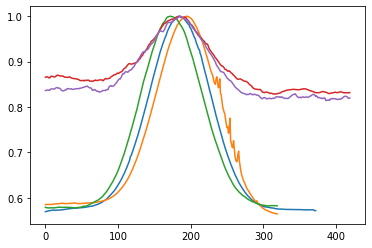

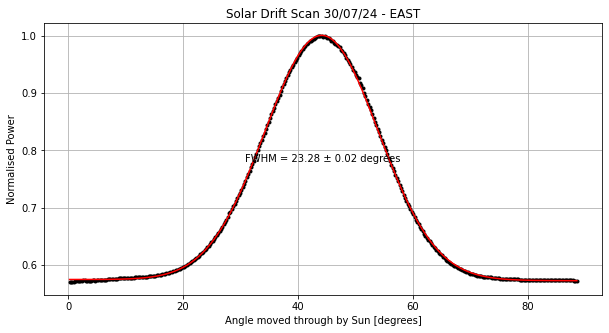

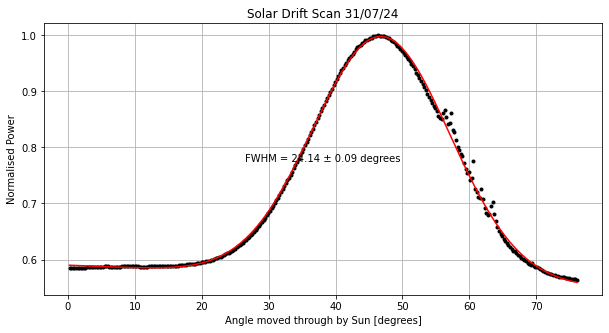

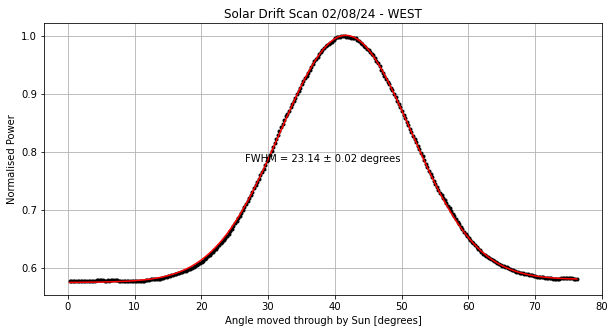

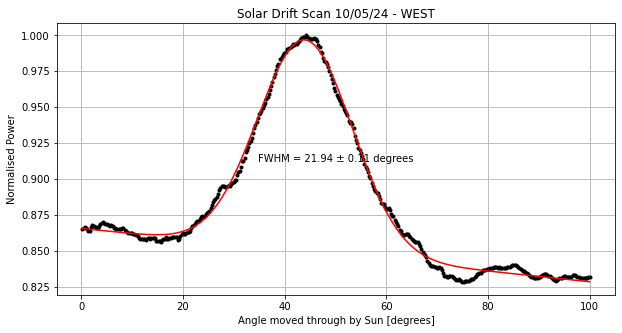

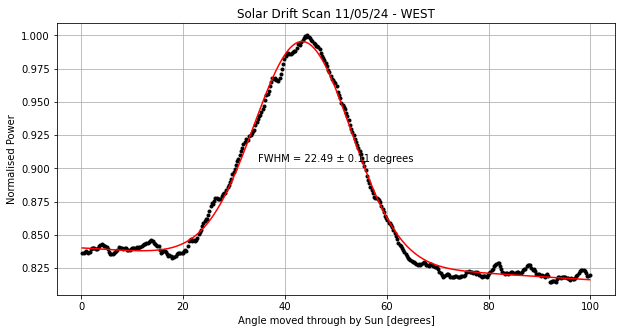

In [4]:
transits = [Transit('30th July 2024', 0, 18.31, 0, 'E', datetime.datetime(2024, 7, 30, 12, 15, 41)),
            Transit('31st July 2024 - solar transit', 0, 18.06, 0, 'E', datetime.datetime(2024, 7, 31, 12, 15, 38)),
            Transit('2nd Aug 2024', 0, 17.55, 0, 'W', datetime.datetime(2024, 8, 2, 12, 15, 31)),
            Transit('10th May 2024', 0, 17.82, 0, 'W', datetime.datetime(2024, 5, 10, 12, 5, 38)),
            Transit('11th May 2024', 0, 18.07, 0, 'W', datetime.datetime(2024, 5, 11, 12, 5, 36)),
            Transit('14th Aug 2024', 0, 14.11, 0, 'E', datetime.datetime(2024, 8, 14, 13, 13, 55)),
            Transit('16th Aug 2024', 0, 13.48, 0, 'W', datetime.datetime(2024, 8, 16, 13, 13, 31)),]

t30, pwr30 = transits[0].get_data()
t31, pwr31 = transits[1].get_data()
t2, pwr2 = transits[2].get_data()
t10, pwr10 = transits[3].get_data()
t11, pwr11 = transits[4].get_data()

tot_pwr30 = (np.average(pwr30[1,10:,112:567], axis=1)/np.max(np.average(pwr30[1,10:,112:567], axis=1)))
tot_pwr31 = (np.average(pwr31[1,:320,112:567], axis=1)/np.max(np.average(pwr31[1,:320,112:567], axis=1)))
tot_pwr2 = (np.average(pwr2[3,20:340,112:567], axis=1)/np.max(np.average(pwr2[3,20:340,112:567], axis=1)))
tot_pwr10 = (np.average(pwr10[3,:,112:567], axis=1)/np.max(np.average(pwr10[3,:,112:567], axis=1)))
tot_pwr11 = (np.average(pwr11[3,:,112:567], axis=1)/np.max(np.average(pwr11[3,:,112:567], axis=1)))

plt.plot(tot_pwr30)
plt.plot(tot_pwr31)
plt.plot(tot_pwr2)
plt.plot(tot_pwr10)
plt.plot(tot_pwr11)

angle30 = np.cos(transits[0].dec_mid*np.pi/180)*np.linspace(1,len(tot_pwr30),len(tot_pwr30)) * 360/(60*24)
angle31 = np.cos(transits[1].dec_mid*np.pi/180)*np.linspace(1,len(tot_pwr31),len(tot_pwr31)) * 360/(60*24)
angle2 = np.cos(transits[2].dec_mid*np.pi/180)*np.linspace(1,len(tot_pwr2),len(tot_pwr2)) * 360/(60*24)
angle10 = np.cos(transits[3].dec_mid*np.pi/180)*np.linspace(1,len(tot_pwr10),len(tot_pwr10)) * 360/(60*24)
angle11 = np.cos(transits[4].dec_mid*np.pi/180)*np.linspace(1,len(tot_pwr11),len(tot_pwr11)) * 360/(60*24)

popt30, pcov30 = gaussian_with_baseline_fitting(angle30, tot_pwr30)
popt31, pcov31 = gaussian_with_baseline_fitting(angle31, tot_pwr31)
popt2, pcov2 = gaussian_with_baseline_fitting(angle2, tot_pwr2)
popt10, pcov10 = gaussian_with_baseline_fitting(angle10, tot_pwr10)
popt11, pcov11 = gaussian_with_baseline_fitting(angle11, tot_pwr11)

fwhm30 = popt30[2]
fwhm_error30 = np.sqrt(np.diag(pcov30)[2])
fwhm31 = popt31[2]
fwhm_error31 = np.sqrt(np.diag(pcov31)[2])
fwhm2 = popt2[2]
fwhm_error2 = np.sqrt(np.diag(pcov2)[2])
fwhm10 = popt10[2]
fwhm_error10 = np.sqrt(np.diag(pcov10)[2])
fwhm11 = popt11[2]
fwhm_error11 = np.sqrt(np.diag(pcov11)[2])

plt.figure(figsize=(10, 5))
plt.plot(angle30, tot_pwr30, "k.")
plt.plot(np.linspace(np.min(angle30), np.max(angle30), 1000), gaussian_with_baseline(np.linspace(np.min(angle30), np.max(angle30), 1000), *popt30), "r")
plt.xlabel('Angle moved through by Sun [degrees]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.title("Solar Drift Scan 30/07/24 - EAST")
plt.annotate(f"FWHM = {fwhm30:.2f} ± {fwhm_error30:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(angle31, tot_pwr31, "k.")
plt.plot(np.linspace(np.min(angle31), np.max(angle31), 1000), gaussian_with_baseline(np.linspace(np.min(angle31), np.max(angle31), 1000), *popt31), "r")
plt.xlabel('Angle moved through by Sun [degrees]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.title("Solar Drift Scan 31/07/24")
plt.annotate(f"FWHM = {fwhm31:.2f} ± {fwhm_error31:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(angle2, tot_pwr2, "k.")
plt.plot(np.linspace(np.min(angle2), np.max(angle2), 1000), gaussian_with_baseline(np.linspace(np.min(angle2), np.max(angle2), 1000), *popt2), "r")
plt.xlabel('Angle moved through by Sun [degrees]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.title("Solar Drift Scan 02/08/24 - WEST")
plt.annotate(f"FWHM = {fwhm2:.2f} ± {fwhm_error2:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
#plt.xlim(0,15)
#plt.ylim(0.577,0.58)
#plt.yscale('log')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(angle10, tot_pwr10, "k.")
plt.plot(np.linspace(np.min(angle10), np.max(angle10), 1000), gaussian_with_baseline(np.linspace(np.min(angle10), np.max(angle10), 1000), *popt10), "r")
plt.xlabel('Angle moved through by Sun [degrees]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.title("Solar Drift Scan 10/05/24 - WEST")
plt.annotate(f"FWHM = {fwhm10:.2f} ± {fwhm_error10:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(angle11, tot_pwr11, "k.")
plt.plot(np.linspace(np.min(angle11), np.max(angle11), 1000), gaussian_with_baseline(np.linspace(np.min(angle11), np.max(angle11), 1000), *popt11), "r")
plt.xlabel('Angle moved through by Sun [degrees]')
plt.ylabel('Normalised Power')
plt.grid(True)
plt.title("Solar Drift Scan 11/05/24 - WEST")
plt.annotate(f"FWHM = {fwhm11:.2f} ± {fwhm_error11:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.show()

23.296064937956217


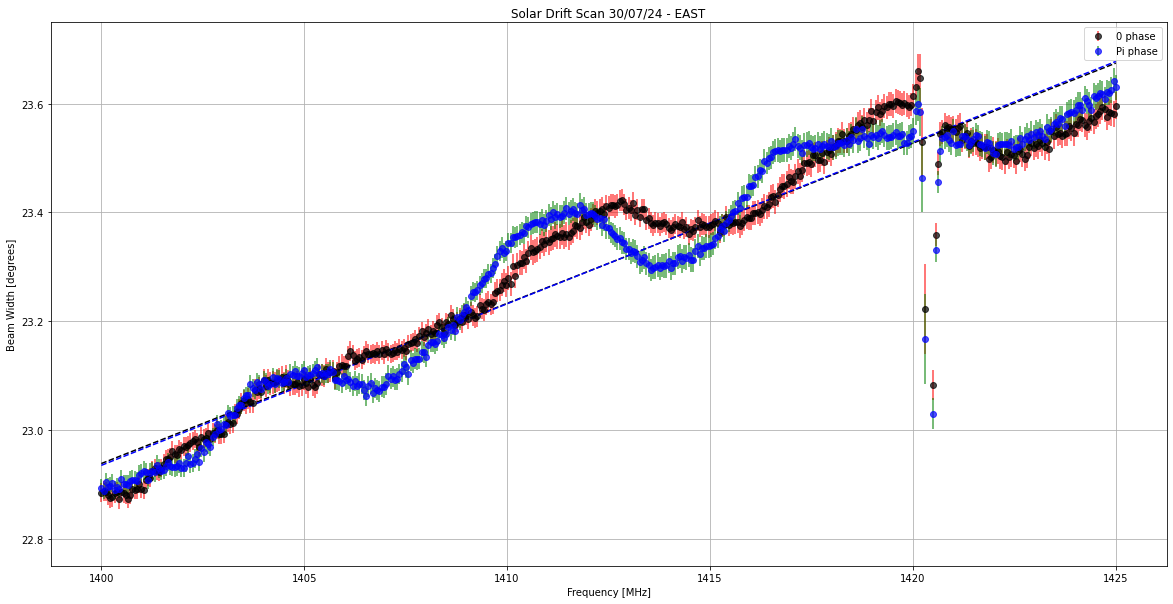

372
23.399958060686977 0.030031538477875503
[  0.02946689 -18.31552181] [1.32445720e-04 1.86884762e-01]
[  0.02972205 -18.67610145] [1.28875395e-04 1.81812388e-01]
0.7366722456160164


In [5]:
fwhm_freq = np.empty((457,2))
fwhm_freq_error = np.empty((457,2))
freq = np.linspace(1400, 1425, 457)

for i in range(112, 569):
    chnl_pwr = pwr30[0][:,i]
    trimmed_pwr = chnl_pwr[10:]
    popt, pcov = gaussian_with_baseline_fitting(angle30, trimmed_pwr)
    fwhm_freq[i-112][0] = popt[2]
    fwhm_freq_error[i-112][0] = np.sqrt(np.diag(pcov)[2])

for i in range(112, 569):
    chnl_pwr = pwr30[1][:,i]
    trimmed_pwr = chnl_pwr[10:]
    popt, pcov = gaussian_with_baseline_fitting(angle30, trimmed_pwr)
    fwhm_freq[i-112][1] = popt[2]
    fwhm_freq_error[i-112][1] = np.sqrt(np.diag(pcov)[2])

fwhm_average = np.average(fwhm_freq)
print(fwhm_average)

line_fit_0, line_errors_0 = line_fitting(freq, fwhm_freq[:,0], fwhm_freq_error[:,0])
line_fit_1, line_errors_1 = line_fitting(freq, fwhm_freq[:,1], fwhm_freq_error[:,1])

plt.figure(figsize=(20, 10))
plt.errorbar(freq, fwhm_freq[:,0], fwhm_freq_error[:,0], fmt="ko", ecolor = "r", alpha=0.7, label = '0 phase')
plt.errorbar(freq, fwhm_freq[:,1], fwhm_freq_error[:,1], fmt="bo", ecolor = "g", alpha=0.7, label = 'Pi phase')
plt.plot(freq, line_fit_0[0]*freq+line_fit_0[1],'--', color="k")
plt.plot(freq, line_fit_1[0]*freq+line_fit_1[1],'--', color='b')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Beam Width [degrees]')
plt.grid(True)
plt.title("Solar Drift Scan 30/07/24 - EAST")
#plt.annotate(f"FWHM = {fwhm:.2f} ± {fwhm_error:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.ylim(22.75,23.75)
plt.legend()
plt.show()

print(np.argmin(np.abs(freq - 1420.405751768)))
print(np.average(fwhm_freq[352:392]), np.average(fwhm_freq_error[352:392]))

print(line_fit_0, line_errors_0)
print(line_fit_1, line_errors_1)
print(line_fit_0[0]*25)

24.17668514747885


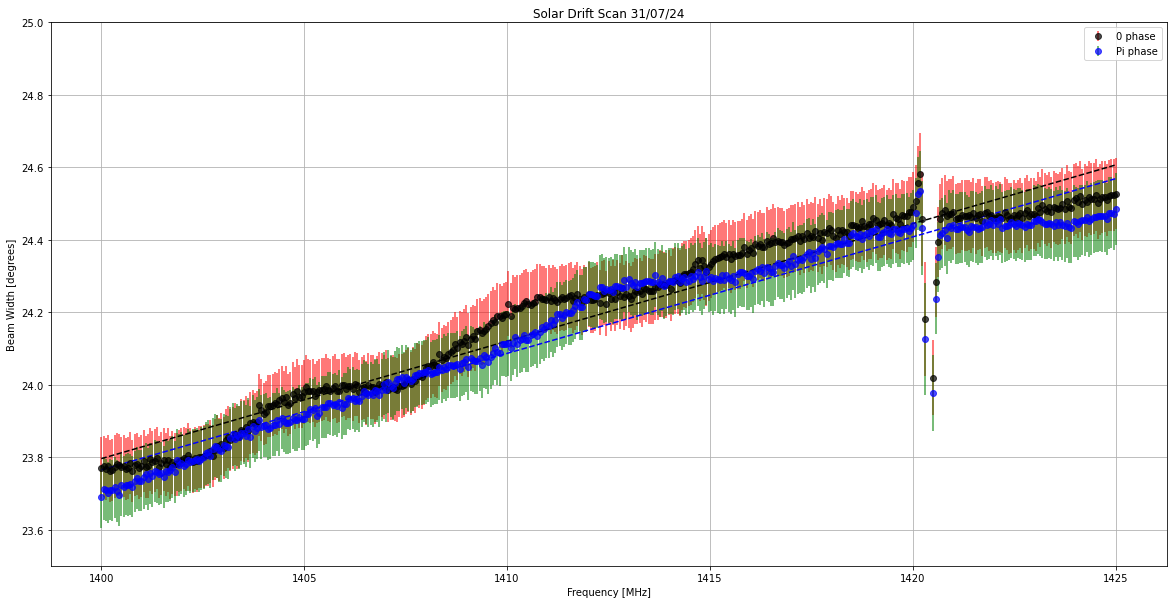

In [6]:
fwhm_freq = np.empty((457,2))
fwhm_freq_error = np.empty((457,2))
freq = np.linspace(1400, 1425, 457)

for i in range(112, 569):
    chnl_pwr = pwr31[0][:,i]
    trimmed_pwr = chnl_pwr[:320]
    popt, pcov = gaussian_with_baseline_fitting(angle31, trimmed_pwr)
    fwhm_freq[i-112][0] = popt[2]
    fwhm_freq_error[i-112][0] = np.sqrt(np.diag(pcov)[2])

for i in range(112, 569):
    chnl_pwr = pwr31[1][:,i]
    trimmed_pwr = chnl_pwr[:320]
    popt, pcov = gaussian_with_baseline_fitting(angle31, trimmed_pwr)
    fwhm_freq[i-112][1] = popt[2]
    fwhm_freq_error[i-112][1] = np.sqrt(np.diag(pcov)[2])

fwhm_average = np.average(fwhm_freq)
print(fwhm_average)

line_fit_0, line_errors_0 = line_fitting(freq, fwhm_freq[:,0], fwhm_freq_error[:,0])
line_fit_1, line_errors_1 = line_fitting(freq, fwhm_freq[:,1], fwhm_freq_error[:,1])

plt.figure(figsize=(20, 10))
plt.errorbar(freq, fwhm_freq[:,0], fwhm_freq_error[:,0], fmt="ko", ecolor = "r", alpha=0.7, label = '0 phase')
plt.errorbar(freq, fwhm_freq[:,1], fwhm_freq_error[:,1], fmt="bo", ecolor = "g", alpha=0.7, label = 'Pi phase')
plt.plot(freq, line_fit_0[0]*freq+line_fit_0[1],'--', color="k")
plt.plot(freq, line_fit_1[0]*freq+line_fit_1[1],'--', color='b')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Beam Width [degrees]')
plt.grid(True)
plt.title("Solar Drift Scan 31/07/24")
#plt.annotate(f"FWHM = {fwhm:.2f} ± {fwhm_error:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.ylim(23.5,25)
plt.legend()
plt.show()

23.157223672051064


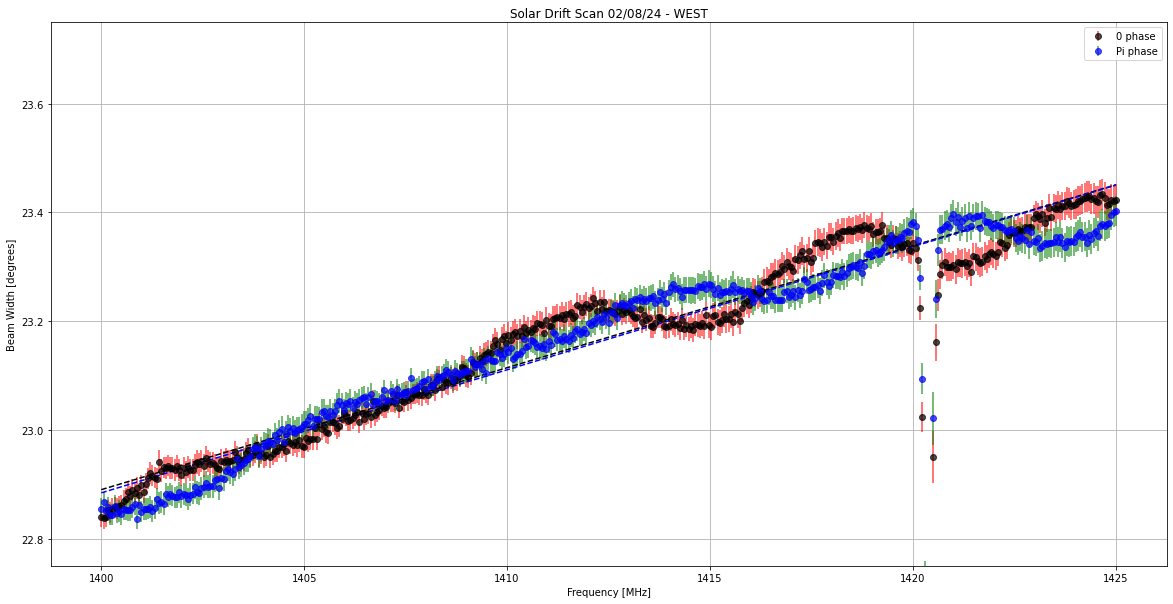

372
23.1953549762986 0.031924222771913244
[ 0.02243792 -8.52302649] [1.48400806e-04 2.09407615e-01]
[ 0.02263959 -8.81122239] [1.51393007e-04 2.13641333e-01]
0.5609478780783427


In [7]:
fwhm_freq = np.empty((457,2))
fwhm_freq_error = np.empty((457,2))
freq = np.linspace(1400, 1425, 457)

for i in range(112, 569):
    chnl_pwr = pwr2[2][:,i]
    trimmed_pwr = chnl_pwr[20:340]
    popt, pcov = gaussian_with_baseline_fitting(angle2, trimmed_pwr)
    fwhm_freq[i-112][0] = popt[2]
    fwhm_freq_error[i-112][0] = np.sqrt(np.diag(pcov)[2])

for i in range(112, 569):
    chnl_pwr = pwr2[3][:,i]
    trimmed_pwr = chnl_pwr[20:340]
    popt, pcov = gaussian_with_baseline_fitting(angle2, trimmed_pwr)
    fwhm_freq[i-112][1] = popt[2]
    fwhm_freq_error[i-112][1] = np.sqrt(np.diag(pcov)[2])

fwhm_average = np.average(fwhm_freq)
print(fwhm_average)

line_fit_0, line_errors_0 = line_fitting(freq, fwhm_freq[:,0], fwhm_freq_error[:,0])
line_fit_1, line_errors_1 = line_fitting(freq, fwhm_freq[:,1], fwhm_freq_error[:,1])

plt.figure(figsize=(20, 10))
plt.errorbar(freq, fwhm_freq[:,0], fwhm_freq_error[:,0], fmt="ko", ecolor = "r", alpha=0.7, label = '0 phase')
plt.errorbar(freq, fwhm_freq[:,1], fwhm_freq_error[:,1], fmt="bo", ecolor = "g", alpha=0.7, label = 'Pi phase')
plt.plot(freq, line_fit_0[0]*freq+line_fit_0[1],'--', color="k")
plt.plot(freq, line_fit_1[0]*freq+line_fit_1[1],'--', color='b')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Beam Width [degrees]')
plt.grid(True)
plt.title("Solar Drift Scan 02/08/24 - WEST")
#plt.annotate(f"FWHM = {fwhm:.2f} ± {fwhm_error:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.ylim(22.75,23.75)
plt.legend()
plt.show()

print(np.argmin(np.abs(freq - 1420.405751768)))
print(np.average(fwhm_freq[352:392]), np.average(fwhm_freq_error[352:392]))

print(line_fit_0, line_errors_0)
print(line_fit_1, line_errors_1)
print(line_fit_0[0]*25)

Finding Peak Height

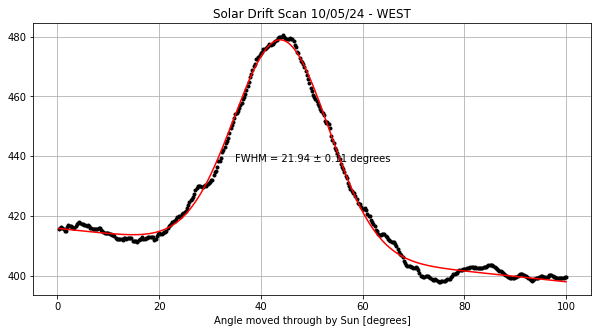

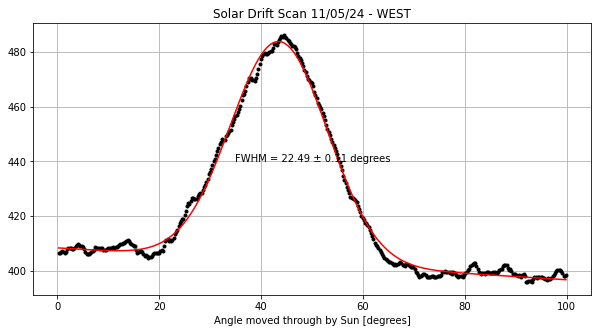

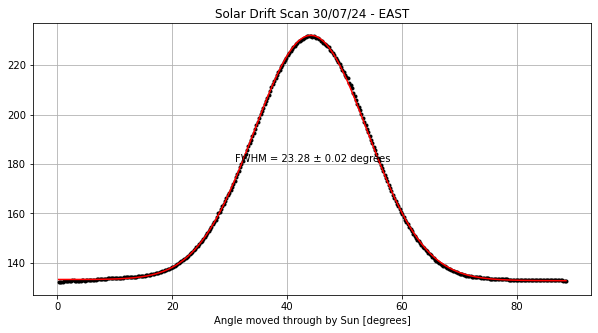

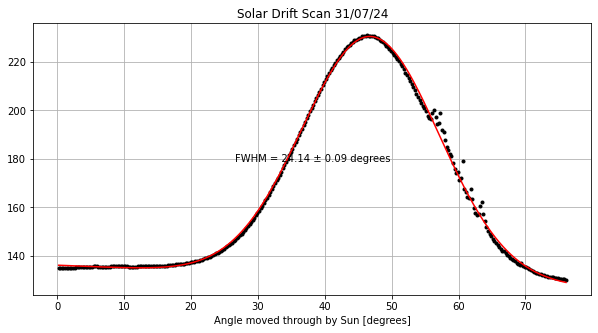

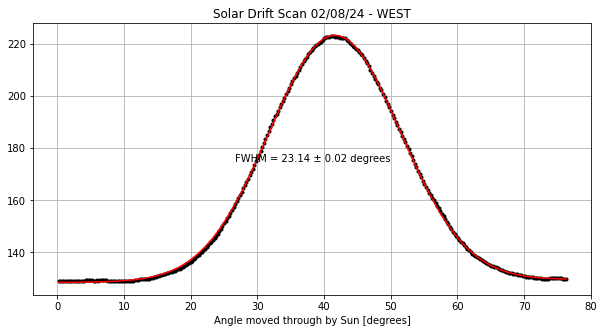

Peak of solar scan Gaussian - baseline [Kelvin]:
10/05/24: 72.39 K
11/05/24: 82.82 K
30/07/24: 98.93 K
31/07/24: 100.09 K
02/08/24: 94.12 K


In [8]:
t30, pwr30 = transits[0].get_data()
t31, pwr31 = transits[1].get_data()
t2, pwr2 = transits[2].get_data()
t10, pwr10 = transits[3].get_data()
t11, pwr11 = transits[4].get_data()

tot_pwr30 = np.average(pwr30[1,10:,112:567], axis=1) *10.65 #10.65 is the conversion factor from au to Kelvin
tot_pwr31 = np.average(pwr31[1,:320,112:567], axis=1) *10.65
tot_pwr2 = np.average(pwr2[3,20:340,112:567], axis=1) *10.65
tot_pwr10 = np.average(pwr10[3,:,112:567], axis=1) *10.65
tot_pwr11 = np.average(pwr11[3,:,112:567], axis=1) *10.65

angle30 = np.cos(transits[0].dec_mid*np.pi/180)*np.linspace(1,len(tot_pwr30),len(tot_pwr30)) * 360/(60*24)
angle31 = np.cos(transits[1].dec_mid*np.pi/180)*np.linspace(1,len(tot_pwr31),len(tot_pwr31)) * 360/(60*24)
angle2 = np.cos(transits[2].dec_mid*np.pi/180)*np.linspace(1,len(tot_pwr2),len(tot_pwr2)) * 360/(60*24)
angle10 = np.cos(transits[3].dec_mid*np.pi/180)*np.linspace(1,len(tot_pwr10),len(tot_pwr10)) * 360/(60*24)
angle11 = np.cos(transits[4].dec_mid*np.pi/180)*np.linspace(1,len(tot_pwr11),len(tot_pwr11)) * 360/(60*24)

popt30, pcov30 = gaussian_with_baseline_fitting(angle30, tot_pwr30)
popt31, pcov31 = gaussian_with_baseline_fitting(angle31, tot_pwr31)
popt2, pcov2 = gaussian_with_baseline_fitting(angle2, tot_pwr2)
popt10, pcov10 = gaussian_with_baseline_fitting(angle10, tot_pwr10)
popt11, pcov11 = gaussian_with_baseline_fitting(angle11, tot_pwr11)

fwhm30 = popt30[2]
fwhm_error30 = np.sqrt(np.diag(pcov30)[2])
fwhm31 = popt31[2]
fwhm_error31 = np.sqrt(np.diag(pcov31)[2])
fwhm2 = popt2[2]
fwhm_error2 = np.sqrt(np.diag(pcov2)[2])
fwhm10 = popt10[2]
fwhm_error10 = np.sqrt(np.diag(pcov10)[2])
fwhm11 = popt11[2]
fwhm_error11 = np.sqrt(np.diag(pcov11)[2])

plt.figure(figsize=(10, 5))
plt.plot(angle10, tot_pwr10, "k.")
plt.plot(np.linspace(np.min(angle10), np.max(angle10), 1000), gaussian_with_baseline(np.linspace(np.min(angle10), np.max(angle10), 1000), *popt10), "r")
plt.xlabel('Angle moved through by Sun [degrees]')
#plt.ylabel('Normalised Power')
plt.grid(True)
plt.title("Solar Drift Scan 10/05/24 - WEST")
plt.annotate(f"FWHM = {fwhm10:.2f} ± {fwhm_error10:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(angle11, tot_pwr11, "k.")
plt.plot(np.linspace(np.min(angle11), np.max(angle11), 1000), gaussian_with_baseline(np.linspace(np.min(angle11), np.max(angle11), 1000), *popt11), "r")
plt.xlabel('Angle moved through by Sun [degrees]')
#plt.ylabel('Normalised Power')
plt.grid(True)
plt.title("Solar Drift Scan 11/05/24 - WEST")
plt.annotate(f"FWHM = {fwhm11:.2f} ± {fwhm_error11:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(angle30, tot_pwr30, "k.")
plt.plot(np.linspace(np.min(angle30), np.max(angle30), 1000), gaussian_with_baseline(np.linspace(np.min(angle30), np.max(angle30), 1000), *popt30), "r")
plt.xlabel('Angle moved through by Sun [degrees]')
#plt.ylabel('Normalised Power')
plt.grid(True)
plt.title("Solar Drift Scan 30/07/24 - EAST")
plt.annotate(f"FWHM = {fwhm30:.2f} ± {fwhm_error30:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(angle31, tot_pwr31, "k.")
plt.plot(np.linspace(np.min(angle31), np.max(angle31), 1000), gaussian_with_baseline(np.linspace(np.min(angle31), np.max(angle31), 1000), *popt31), "r")
plt.xlabel('Angle moved through by Sun [degrees]')
#plt.ylabel('Normalised Power')
plt.grid(True)
plt.title("Solar Drift Scan 31/07/24")
plt.annotate(f"FWHM = {fwhm31:.2f} ± {fwhm_error31:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(angle2, tot_pwr2, "k.")
plt.plot(np.linspace(np.min(angle2), np.max(angle2), 1000), gaussian_with_baseline(np.linspace(np.min(angle2), np.max(angle2), 1000), *popt2), "r")
plt.xlabel('Angle moved through by Sun [degrees]')
#plt.ylabel('Normalised Power')
plt.grid(True)
plt.title("Solar Drift Scan 02/08/24 - WEST")
plt.annotate(f"FWHM = {fwhm2:.2f} ± {fwhm_error2:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
plt.show()

print("Peak of solar scan Gaussian - baseline [Kelvin]:")
print("10/05/24: {0:3.2f} K".format(np.max(tot_pwr10) - (popt10[4]*angle10[np.argmax(tot_pwr10)] + popt10[3])))
print("11/05/24: {0:3.2f} K".format(np.max(tot_pwr11) - (popt11[4]*angle11[np.argmax(tot_pwr11)] + popt11[3])))
print("30/07/24: {0:3.2f} K".format(np.max(tot_pwr30) - (popt30[4]*angle30[np.argmax(tot_pwr30)] + popt30[3])))
print("31/07/24: {0:3.2f} K".format(np.max(tot_pwr31) - (popt31[4]*angle31[np.argmax(tot_pwr31)] + popt31[3])))
print("02/08/24: {0:3.2f} K".format(np.max(tot_pwr2) - (popt2[4]*angle2[np.argmax(tot_pwr2)] + popt2[3])))

Functions

In [9]:
def total_power_scan(transit, cw, start, end):
    
    if transit.horn == 'E':
        int1 = 0
        int2 = 1
        int3 = 2
        int4 = 3
    elif transit.horn == 'W':
        int1 = 2
        int2 = 3
        int3 = 0
        int4 = 1

    t, pwr = transit.get_data()

    if cw == 1:
        cw_chan1 = np.argmax(pwr[int1][int(len(pwr[int1])/2), 112:567])
        cw_chan2 = np.argmax(pwr[int3][int(len(pwr[int3])/2), 112:567])
        print(cw_chan1, cw_chan2)
        for i in range(0,len(pwr[int1])):
            for j in range(cw_chan1 - 2 + 112, cw_chan1 + 2 + 112):
                pwr[int1][i, j] = np.nan
                pwr[int2][i, j] = np.nan
            for j in range(cw_chan2 - 2 + 112, cw_chan2 + 2 + 112):
                pwr[int1][i, j] = np.nan
                pwr[int2][i, j] = np.nan
    
    tot_pwr = np.nanmean(pwr[int1,start:end,112:567], axis=1) *10.65 #10.65 is the conversion factor from au to Kelvin
    angle = np.cos(transit.dec_mid*np.pi/180)*np.linspace(1,len(tot_pwr),len(tot_pwr)) * 360/(60*24)

    popt, pcov = gaussian_with_baseline_fitting(angle, tot_pwr)


    fwhm = popt[2]
    fwhm_error = np.sqrt(np.diag(pcov)[2])


    plt.figure(figsize=(10, 5))
    plt.plot(angle, tot_pwr, "k.")
    plt.plot(np.linspace(np.min(angle), np.max(angle), 1000), gaussian_with_baseline(np.linspace(np.min(angle), np.max(angle), 1000), *popt), "r")
    plt.xlabel('Angle moved through by Sun [degrees]')
    plt.ylabel('Brightness Temperature [K]')
    plt.grid(True)
    plt.title("Solar Drift Scan {0} - {1}".format(transit.date, transit.horn))
    plt.annotate(f"FWHM = {fwhm:.2f} ± {fwhm_error:.2f} degrees", (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
    plt.show()

    fwhm_freq = np.empty((457,2))
    fwhm_freq_error = np.empty((457,2))
    freq = np.linspace(1400, 1425, 457)

    for i in range(112, 569):
        chnl_pwr = pwr[int1][start:end,i]
        trimmed_pwr = np.nan_to_num(chnl_pwr, nan=0.0)
        popt, pcov = gaussian_with_baseline_fitting(angle, trimmed_pwr)
        fwhm_freq[i-112][0] = popt[2]
        fwhm_freq_error[i-112][0] = np.sqrt(np.diag(pcov)[2])

    for i in range(112, 569):
        chnl_pwr = pwr[int2][start:end,i]
        trimmed_pwr = np.nan_to_num(chnl_pwr, nan=0.0)
        popt, pcov = gaussian_with_baseline_fitting(angle, trimmed_pwr)
        fwhm_freq[i-112][1] = popt[2]
        fwhm_freq_error[i-112][1] = np.sqrt(np.diag(pcov)[2])

    fwhm_average = np.average(fwhm_freq)
    print(fwhm_average)

    line_fit_0, line_errors_0 = line_fitting(freq, fwhm_freq[:,0], fwhm_freq_error[:,0])
    line_fit_1, line_errors_1 = line_fitting(freq, fwhm_freq[:,1], fwhm_freq_error[:,1])

    plt.figure(figsize=(20, 10))
    plt.errorbar(freq, fwhm_freq[:,0], fwhm_freq_error[:,0], fmt="ko", ecolor = "r", alpha=0.7, label = '0 phase')
    plt.errorbar(freq, fwhm_freq[:,1], fwhm_freq_error[:,1], fmt="bo", ecolor = "g", alpha=0.7, label = 'Pi phase')
    plt.plot(freq, line_fit_0[0]*freq+line_fit_0[1],'--', color="k")
    plt.plot(freq, line_fit_1[0]*freq+line_fit_1[1],'--', color='b')
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Beam Width [degrees]')
    plt.grid(True)
    plt.title("Solar Drift Scan {0} - {1}".format(transit.date, transit.horn))
    #plt.ylim(14,15)
    plt.legend()
    plt.show()

    print(line_fit_0, line_errors_0)
    print(line_fit_1, line_errors_1)
    print(line_fit_0[0]*25)


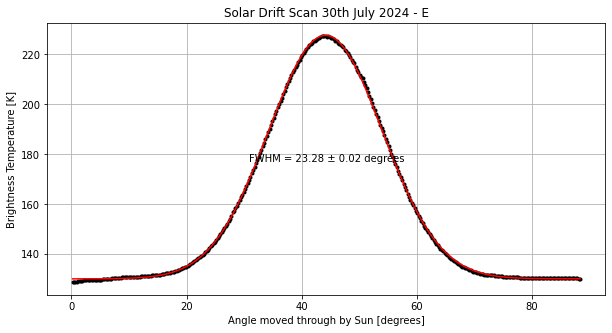

23.295650266326934


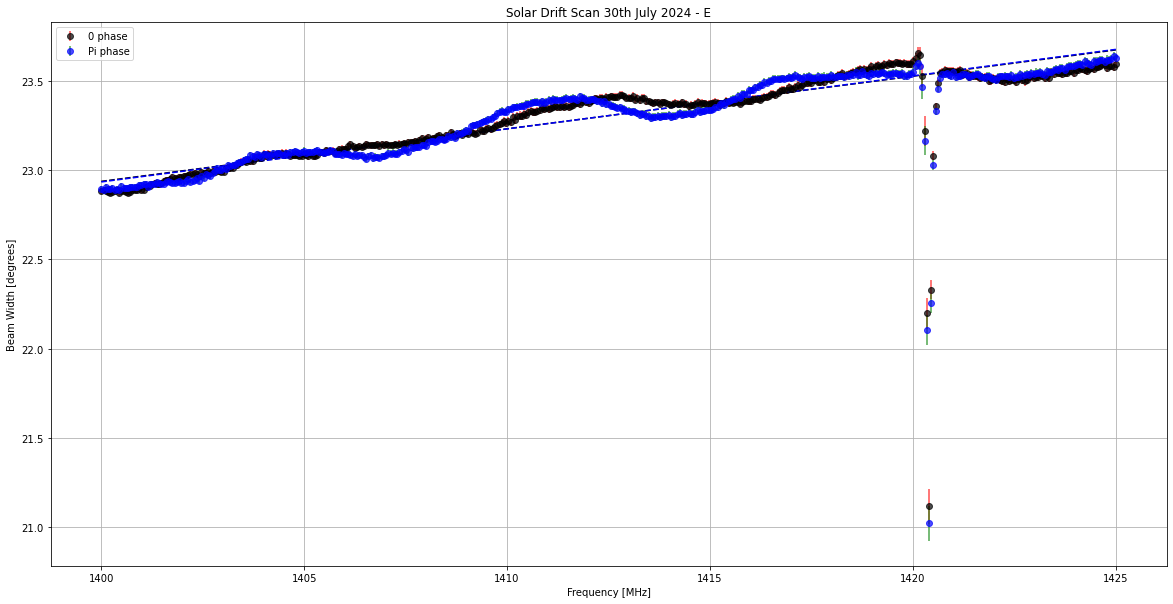

[  0.02946777 -18.3172457 ] [1.32691221e-04 1.87231186e-01]
[  0.02972647 -18.68272034] [1.29110334e-04 1.82143496e-01]
0.7366942158766531


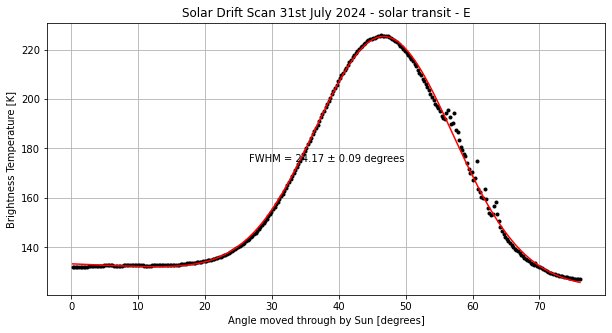

24.17668514747885


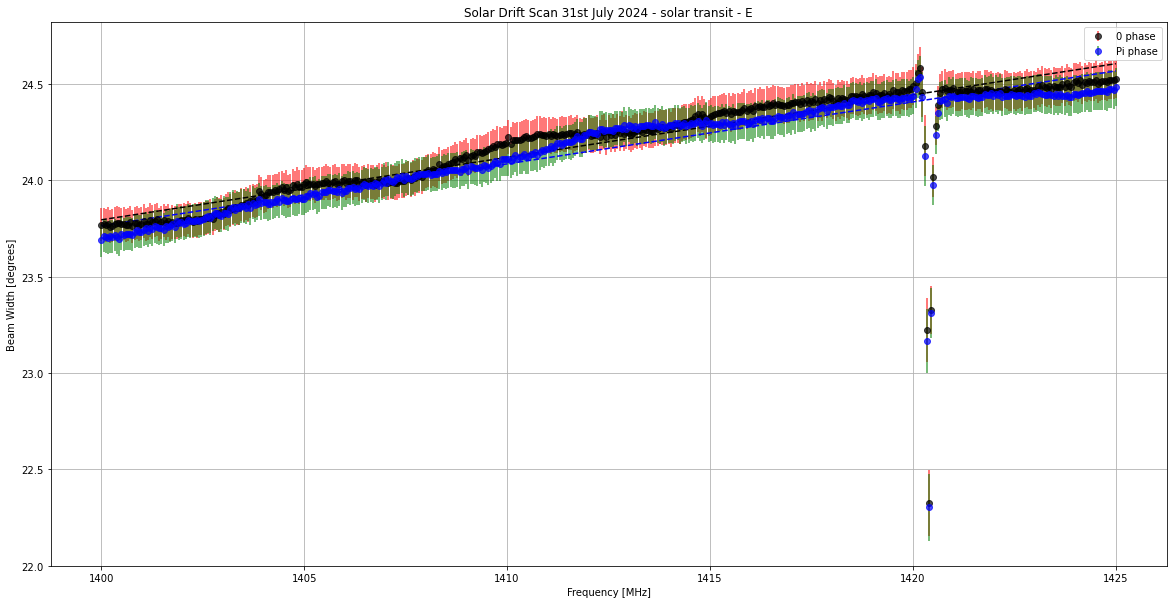

[  0.03242307 -21.59660958] [5.95204430e-04 8.40311337e-01]
[  0.03215719 -21.25551152] [5.93851003e-04 8.38396799e-01]
0.8105767442363659


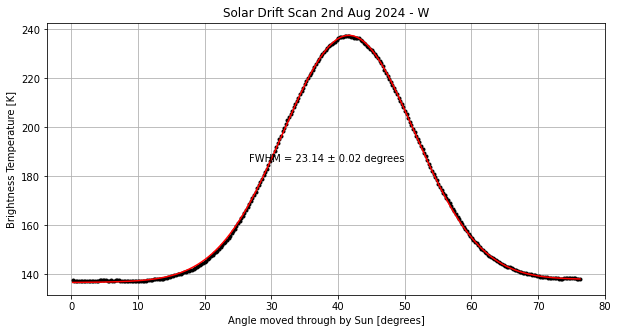

23.157223672051064


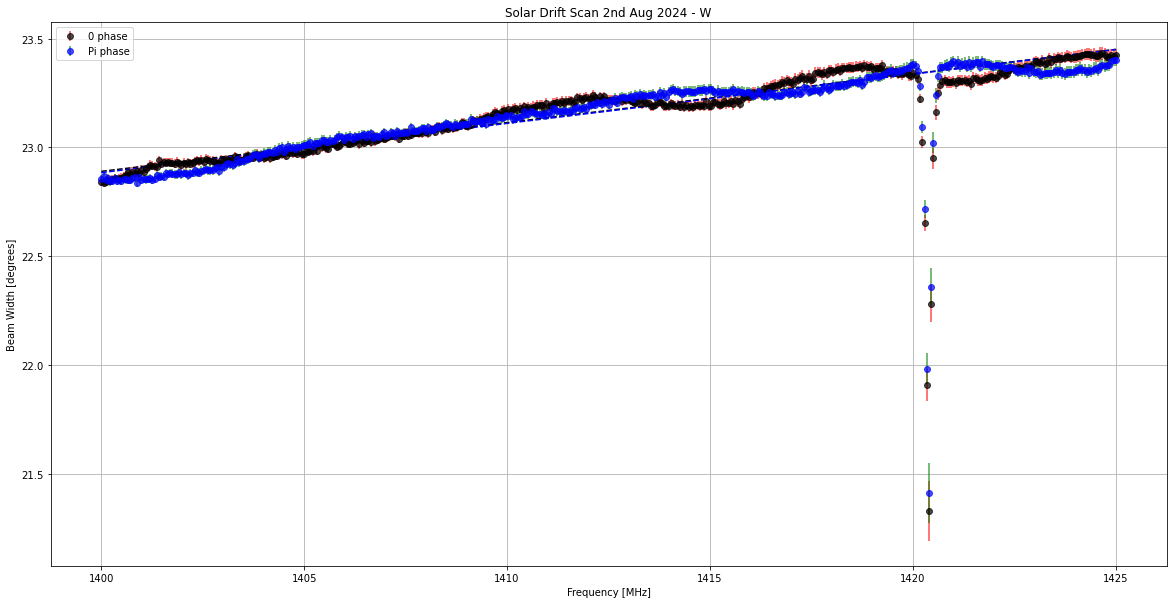

[ 0.02243792 -8.52302649] [1.48400806e-04 2.09407615e-01]
[ 0.02263959 -8.81122239] [1.51393007e-04 2.13641333e-01]
0.5609478780783427
252 242


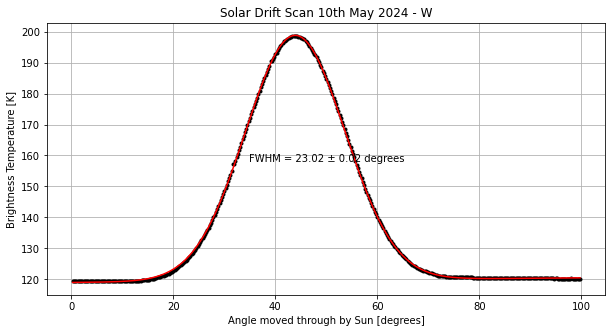

c:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


23.033728758769843


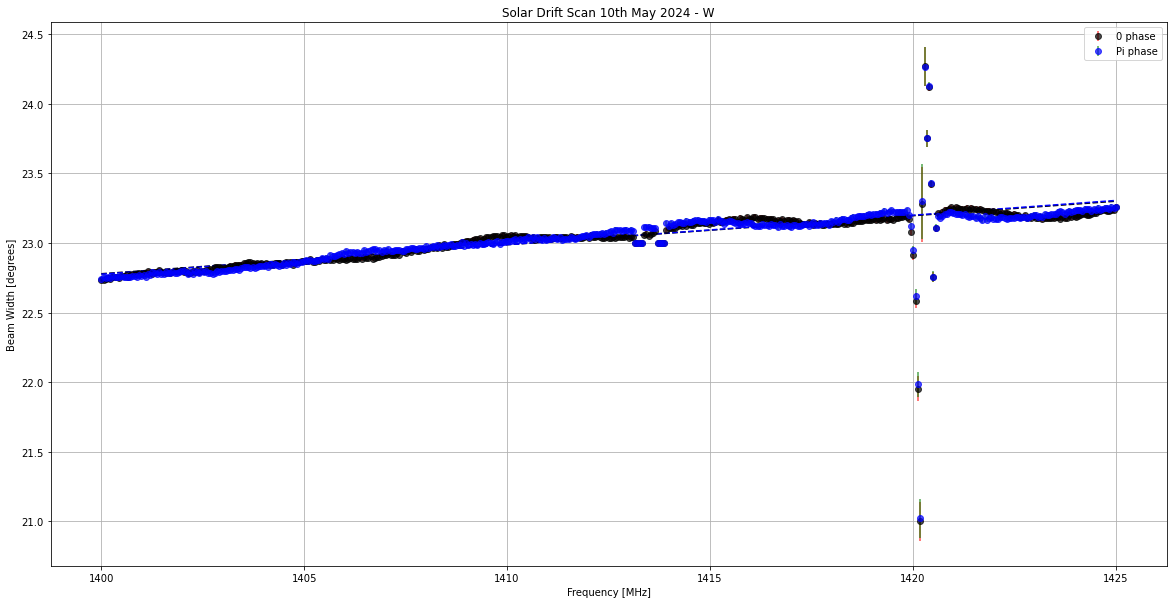

[ 0.02086032 -6.42534873] [1.12232819e-04 1.58352603e-01]
[ 0.0212186  -6.93020837] [1.11135047e-04 1.56803731e-01]
0.5215080862499253
252 242


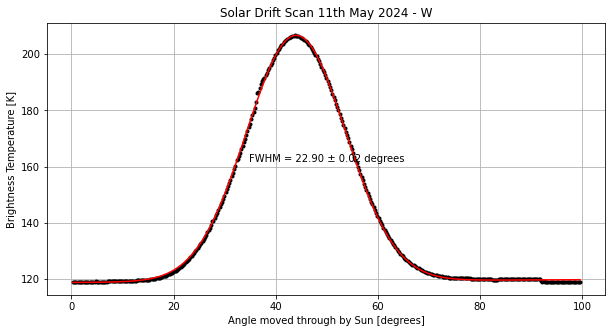

c:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


22.9132648323919


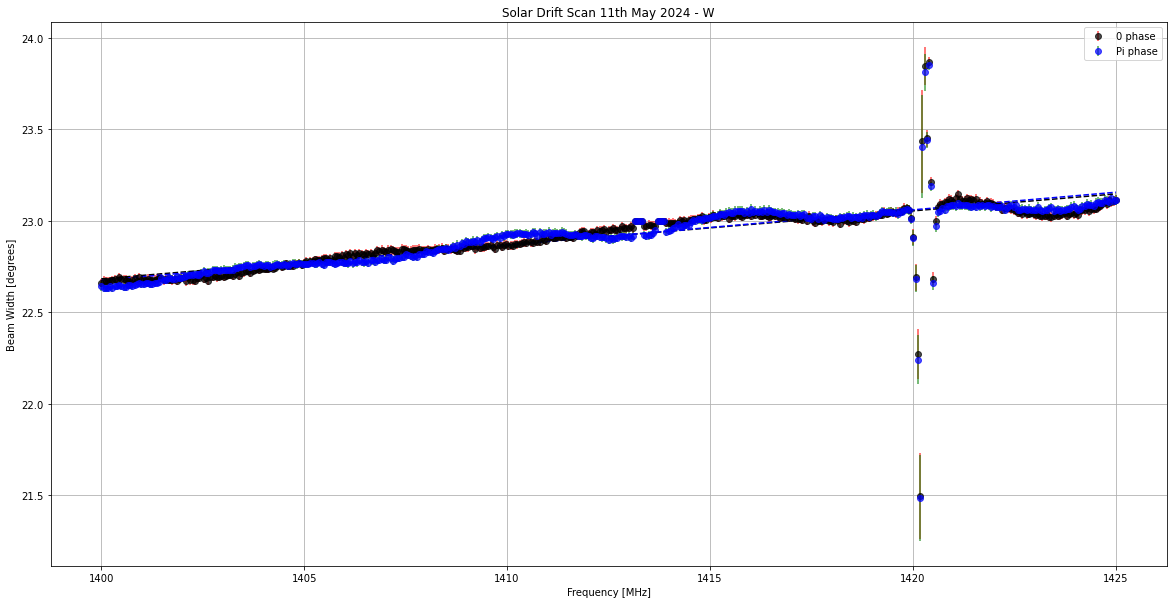

[ 0.01855379 -3.29247157] [1.56826323e-04 2.21432745e-01]
[ 0.01922785 -4.24391481] [1.53884337e-04 2.17254788e-01]
0.46384471811533257
244 252


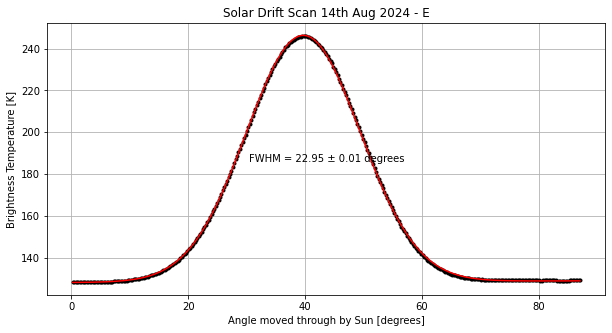

c:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


22.963930078541182


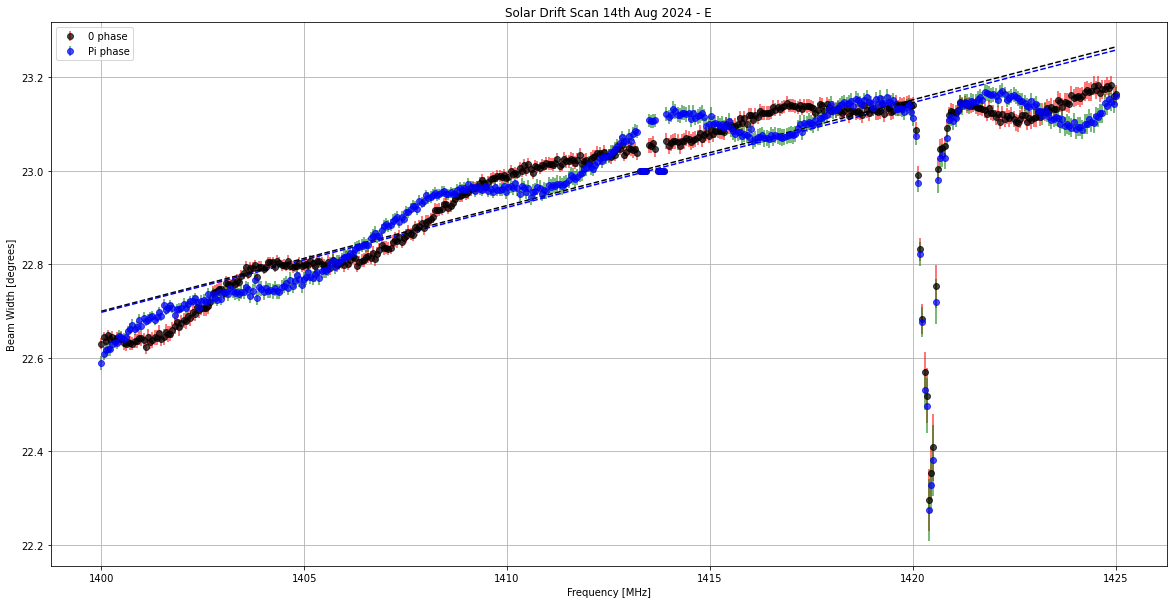

[ 0.02261747 -8.96483061] [1.03221758e-04 1.45656148e-01]
[ 0.02243327 -8.70921369] [1.00700456e-04 1.42039190e-01]
0.5654367416328133


In [10]:
total_power_scan(transits[0], 0, 10, -1)
total_power_scan(transits[1], 0, 0, 320)
total_power_scan(transits[2], 0, 20, 340)
total_power_scan(transits[3], 1, 0, -1)
total_power_scan(transits[4], 1, 0, -1)
total_power_scan(transits[5], 1, 0, -1)

252 244


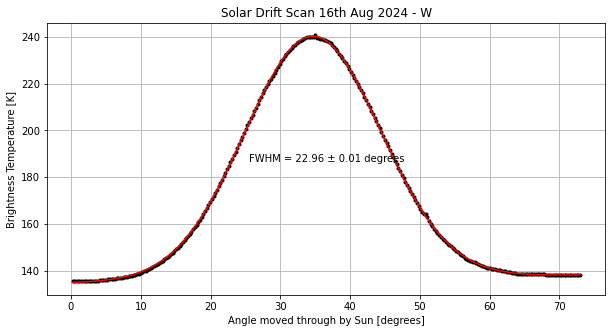

c:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


22.98229648093608


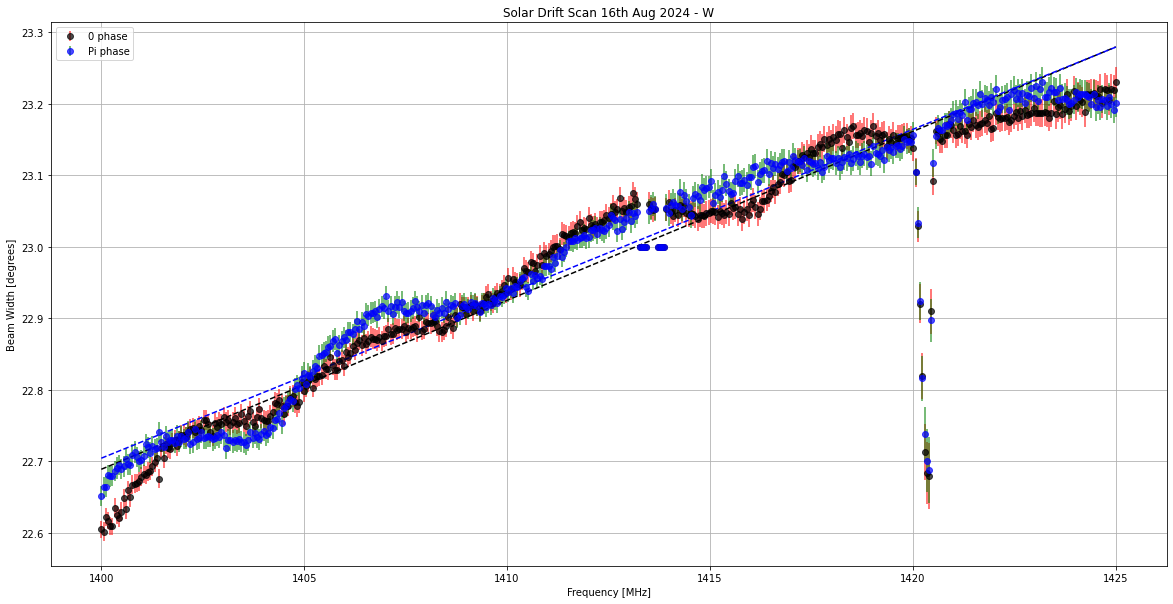

[  0.02364879 -10.41980512] [1.06074753e-04 1.49638697e-01]
[ 0.02301987 -9.52383123] [1.08898023e-04 1.53659348e-01]
0.5912196524631738


In [21]:
total_power_scan(transits[6], 1, 20, 320)